**Задача 2. Сравнение методов классификации**

Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

from sklearn import model_selection
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [ ]:
def e_metrics(x1, x2):
    return np.sqrt(np.sum((x2-x1)**2))

Реализуем алгоритм поиска k ближайших соседей.

In [ ]:
def knn_(x_train, y_train, x_test, k):
    
    X_train_np=X_train.to_numpy()
    X_test_np=X_test.to_numpy()
    y_train_np=y_train.to_numpy()
    answers = []
    for x in X_test_np:
        test_distances = []
            
        for i in range(len(X_train_np)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, X_train_np[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train_np[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train_np)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

Напишем функцию для вычисления точности

In [ ]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Функция для подбора гиперпараметра k для алгоритма knn

In [ ]:
def selection_k(x_train, y_train, x_test, k_):
  accur = []
  for k in k_: 
    y_pred = knn_(X_train, y_train, X_test, k)
    acc = accuracy(y_pred, y_test)
    accur.append(acc)
    print(f'Точность алгоритма при k = {k}: {acc:.3f}')
  return max(accur)

Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (Data Cleaning).

Описание датасета:

* age - age in years
* sex - (1 = male; 0 = female)
* cp - chest pain type (тип боли в груди)
* trestbps - resting blood pressure (in mm Hg on admission to the hospital) (артериальное давление в покое (в мм рт.ст. при поступлении в стационар))
* chol - serum cholestoral in mg/dl (холестерин в сыворотке в мг/дл)
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) (уровень сахара в крови натощак > 120 мг/дл) (1 = верно; 0 = неверно)
* restecg - resting electrocardiographic results (результаты электрокардиографии в покое)
* thalach - maximum heart rate achieved (достигнута максимальная частота сердечных сокращений)
* exang - exercise induced angina (1 = yes; 0 = no) (стенокардия, вызванная физической нагрузкой (1 = да; 0 = нет))
* oldpeak - ST depression induced by exercise relative to rest (депрессия ST, вызванная физической нагрузкой, по сравнению с состоянием покоя)
* slope - the slope of the peak exercise ST segment (наклон пикового сегмента ST упражнения)
* ca - number of major vessels (0-3) colored by flourosopy (количество крупных сосудов (0-3), окрашенных при флюороскопии)
* thal - 3 = normal; 6 = fixed defect; 7 = reversable defect (нормальный; 6 = фиксированный дефект; 7 = обратимый дефект)
* target - have disease or not (1=yes, 0=no) (есть заболевание или нет (1=да, 0=нет))

Необходимо решить задачу классификации и научиться предсказывать целовой признак target имеет ли пациент заболевание сердца.

In [ ]:
df = pd.read_csv("heart.csv")

In [ ]:
df.head()

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [ ]:
df.shape

(1025, 15)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1025 non-null   int64  
 1   age         1025 non-null   int64  
 2   sex         1025 non-null   int64  
 3   cp          1025 non-null   int64  
 4   trestbps    1025 non-null   int64  
 5   chol        1025 non-null   int64  
 6   fbs         1025 non-null   int64  
 7   restecg     1025 non-null   int64  
 8   thalach     1025 non-null   int64  
 9   exang       1025 non-null   int64  
 10  oldpeak     1025 non-null   float64
 11  slope       1025 non-null   int64  
 12  ca          1025 non-null   int64  
 13  thal        1025 non-null   int64  
 14  target      1025 non-null   int64  
dtypes: float64(1), int64(14)
memory usage: 120.2 KB


Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1025.0,512.000000,296.036315,0.0,256.0,512.0,768.0,1024.0
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
sex,1025.0,0.695610,0.460373,0.0,0.0,1.0,1.0,1.0
cp,1025.0,0.942439,1.029641,0.0,0.0,1.0,2.0,3.0
trestbps,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
fbs,1025.0,0.149268,0.356527,0.0,0.0,0.0,0.0,1.0
restecg,1025.0,0.529756,0.527878,0.0,0.0,1.0,1.0,2.0
thalach,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
exang,1025.0,0.336585,0.472772,0.0,0.0,0.0,1.0,1.0


In [ ]:
df.target.value_counts()

1    526
0    499
Name: target, dtype: int64

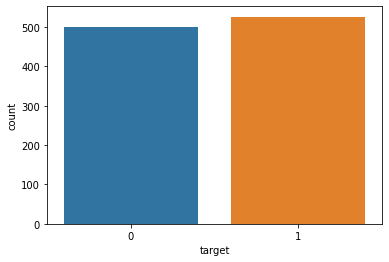

In [ ]:
sns.countplot(x="target", data=df)
plt.show()

Из данных видно что целевая переменная сбалансирована.

In [ ]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b1c2fe810>,
      dtype=object)

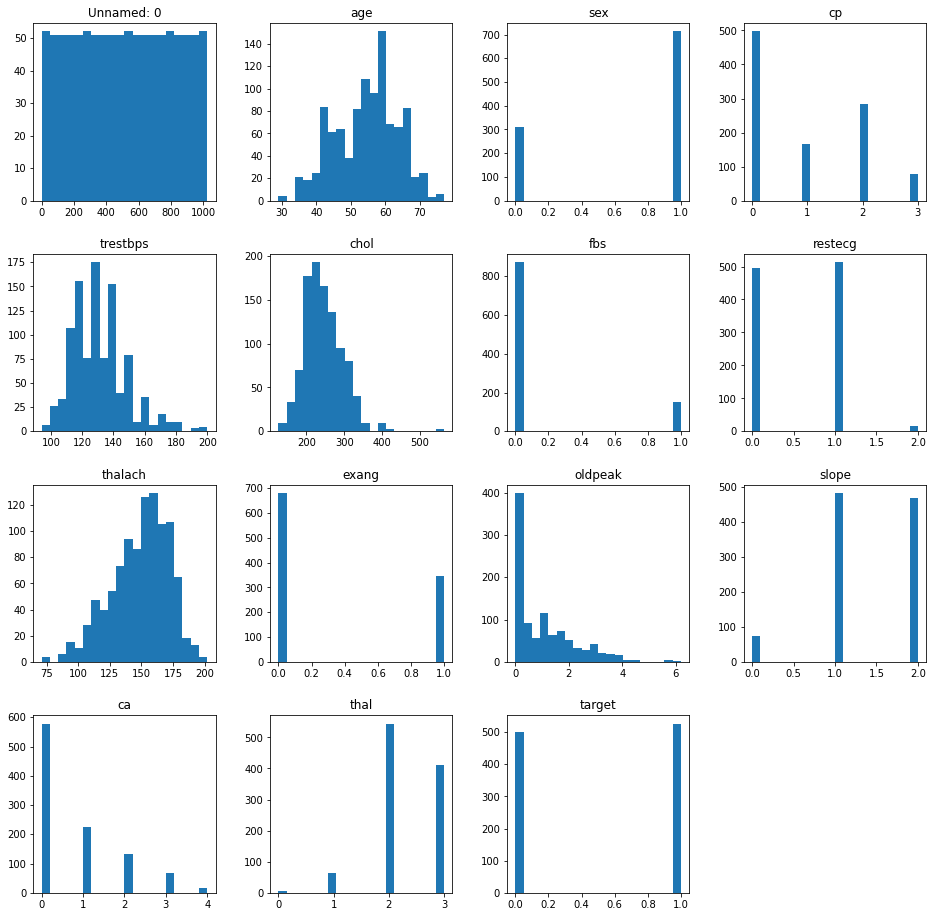

In [ ]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False)

Распределение признаков в датасете показывает необходимость кодирования категориальных признаков (8 фичей), а также показывает нормальное распределение дискретных величин практически на всех признаках. Также необходимо удалить столбец с порядковыми номерами объектов.

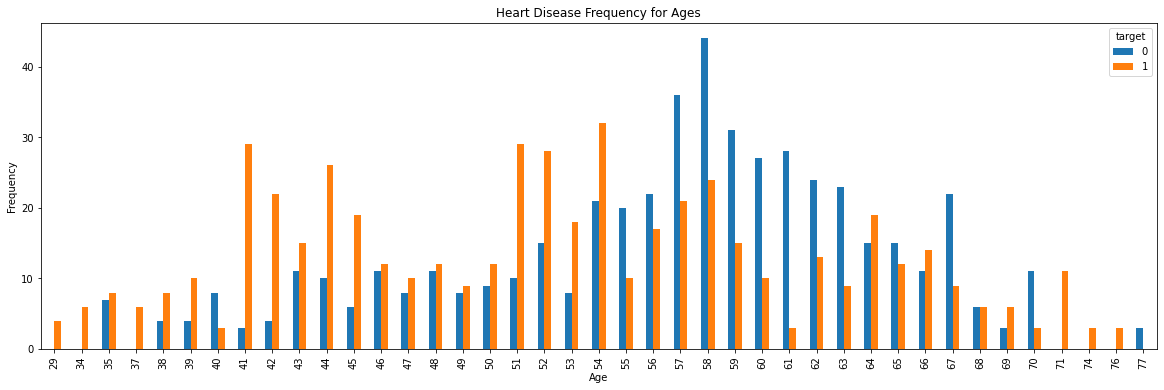

In [ ]:
pd.crosstab(df.age,df.target).plot(kind="bar", figsize=(20, 6))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Гистограмма показывает, как целевая переменная (наличие СС заболевания) зависит от возраста пациента. Можно предположить, что более молодые пациенты приходят на обследование при наличии симптомов, поэтому процент существования заболевания значительно больше, нежели у пациентов в более зрелом возрасте, которые проходят обследование в том числе в качестве "профилактики"

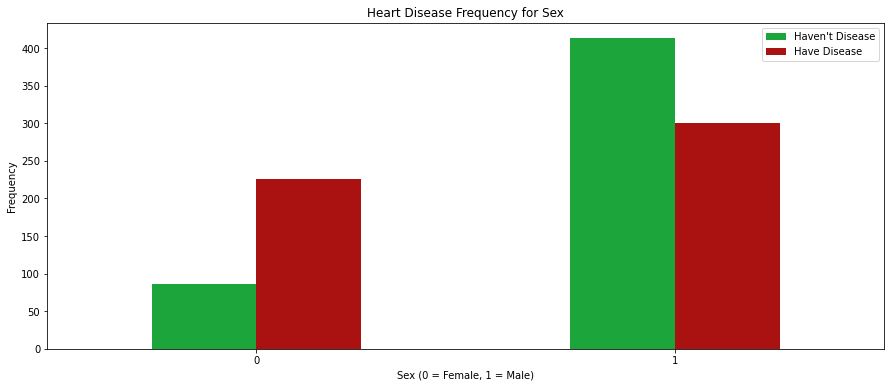

In [ ]:
pd.crosstab(df.sex,df.target).plot(kind="bar", figsize=(15, 6), color=['#1CA53B', '#AA1111' ])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

Гистограмма показывает, что у женщины вероятность иметь СС заболевание выше, чем у мужчины.

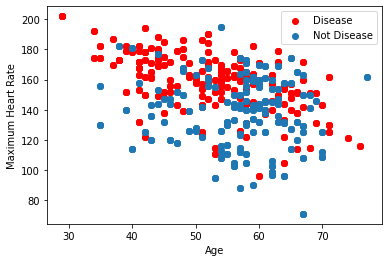

In [ ]:
plt.scatter(x=df.age[df.target==1], y=df.thalach[(df.target==1)], c="red")
plt.scatter(x=df.age[df.target==0], y=df.thalach[(df.target==0)])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate")
plt.show()

Из графика видно, что с возрастом учащенное сердцебиение не является однозначным признаком наличия СС заболевания. В то время как для более молодых пациентов это явный сигнал.

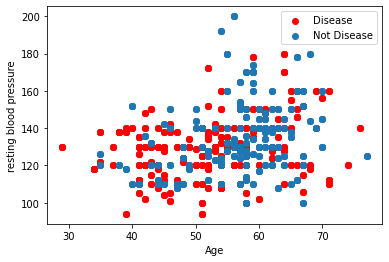

In [ ]:
plt.scatter(x=df.age[df.target==1], y=df.trestbps[(df.target==1)], c="red")
plt.scatter(x=df.age[df.target==0], y=df.trestbps[(df.target==0)])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("Age")
plt.ylabel("resting blood pressure")
plt.show()

Из графика видно, что у пациентов в возрасте старше 50 лет наблюдается повышенное артериальное давление, но этот признак не является однозначным показателем наличия СС заболевания.

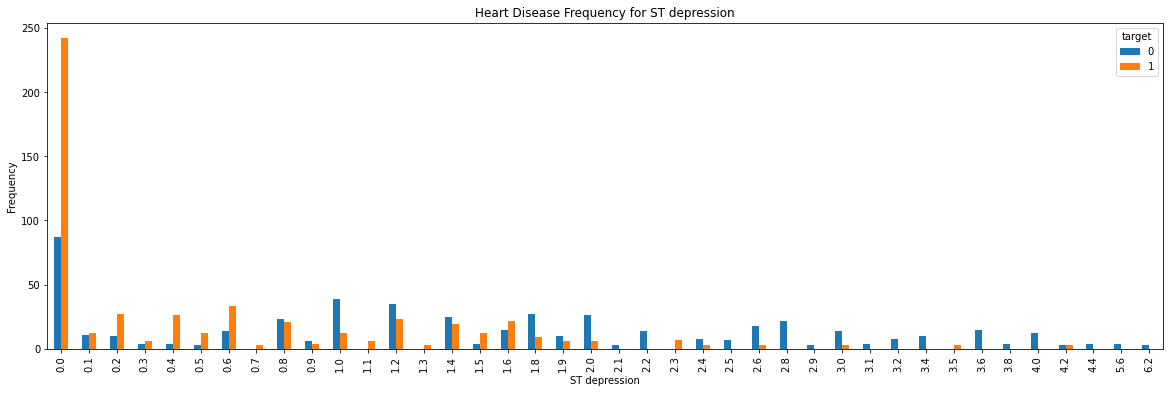

In [ ]:
pd.crosstab(df.oldpeak,df.target).plot(kind="bar", figsize=(20, 6))
plt.title('Heart Disease Frequency for ST depression')
plt.xlabel('ST depression')
plt.ylabel('Frequency')
plt.show()

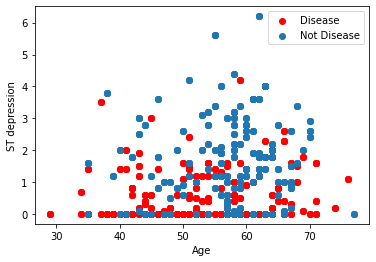

In [ ]:
plt.scatter(x=df.age[df.target==1], y=df.oldpeak[(df.target==1)], c="red")
plt.scatter(x=df.age[df.target==0], y=df.oldpeak[(df.target==0)])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("Age")
plt.ylabel("ST depression")
plt.show()

Из двух верхних графиков видно, что при значении депрессии сегмента ST от 2 и выше, СС заболевания встречаются значительно реже. 

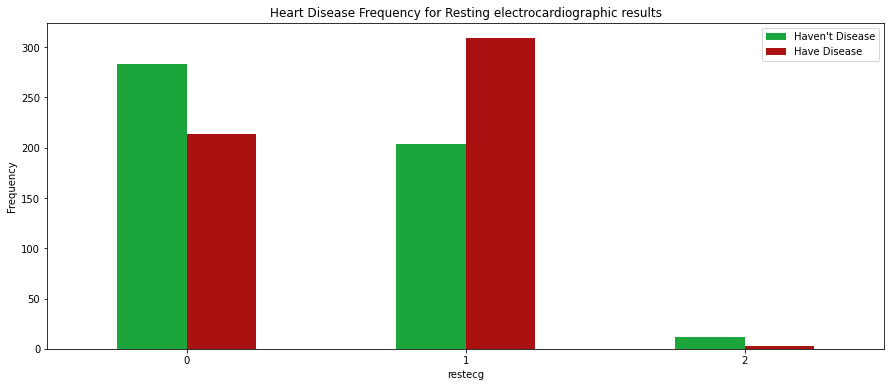

In [ ]:
pd.crosstab(df.restecg,df.target).plot(kind="bar", figsize=(15, 6), color=['#1CA53B', '#AA1111' ])
plt.title('Heart Disease Frequency for Resting electrocardiographic results')
plt.xlabel('restecg')
plt.xticks(rotation=0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

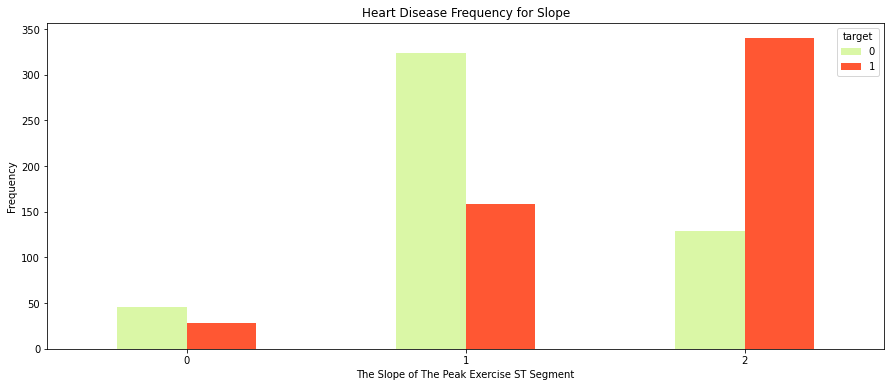

In [ ]:
pd.crosstab(df.slope,df.target).plot(kind="bar", figsize=(15, 6), color=['#DAF7A6','#FF5733' ])
plt.title('Heart Disease Frequency for Slope')
plt.xlabel('The Slope of The Peak Exercise ST Segment')
plt.xticks(rotation = 0)
plt.ylabel('Frequency')
plt.show()

# Замена пропусков

Проверяем общее количество пропущенных значений.

In [ ]:
df.isnull().sum()

Unnamed: 0    0
age           0
sex           0
cp            0
trestbps      0
chol          0
fbs           0
restecg       0
thalach       0
exang         0
oldpeak       0
slope         0
ca            0
thal          0
target        0
dtype: int64

В датасете пропуски отсутствуют

#Корреляция признаков

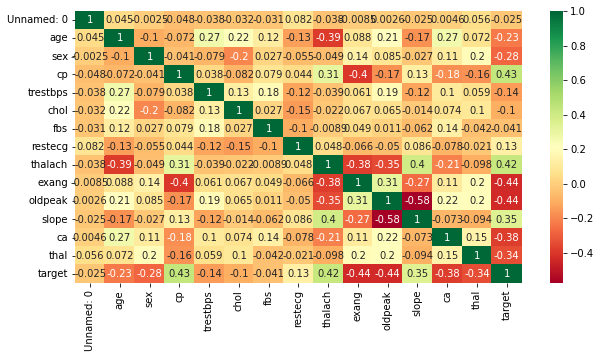

In [ ]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Из таблицы корреляции видно что есть несколько признаков, которые вносят весомый вклад в значение целевой переменной.

#Feature Engineering

Удаление ненужных признаков

Удалим порядковый номер экземпляра, он не несет никакого смысла в качестве признака для обучения модели.

In [ ]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

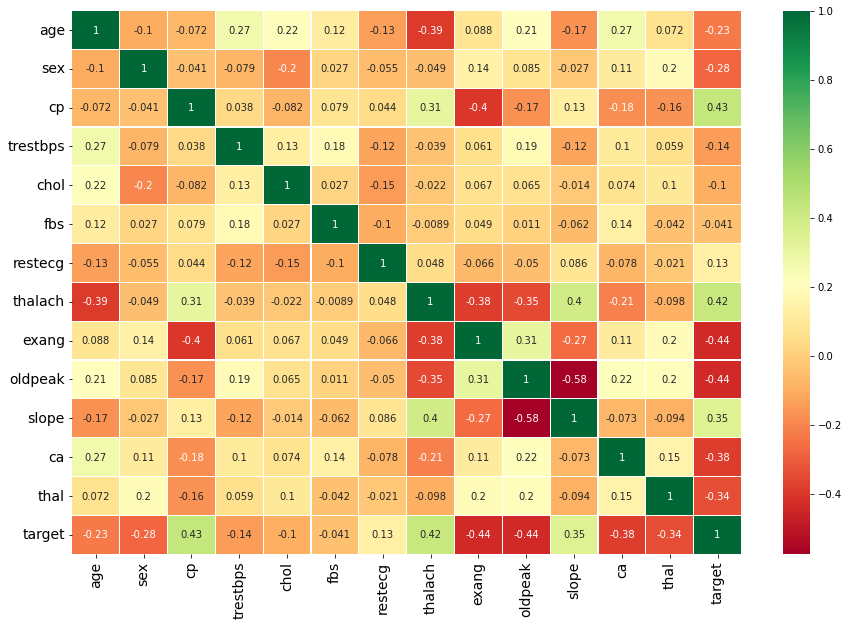

In [ ]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2, annot_kws={'size':10})
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
df['ca'].value_counts()

0    578
1    226
2    134
3     69
4     18
Name: ca, dtype: int64

В описании датасета указано что данный признак может варьироваться в диапазоне от 0 до 3. Соответственно, значение 4 в данном случае это выбросы. Присоединим их к категории 3.

In [ ]:
df.loc[df['ca'] > 3, 'ca'] = 3
df['ca'].value_counts()

0    578
1    226
2    134
3     87
Name: ca, dtype: int64

Преобразование категориальных признаков

Закодируем категориальные признаки cp, restecg, slope, ca и thal.

In [ ]:
cp_dum = pd.get_dummies(df['cp'], prefix = "cp")
restecg_dum = pd.get_dummies(df['restecg'], prefix = "restecg")
slope_dum = pd.get_dummies(df['slope'], prefix = "slope")
ca_dum = pd.get_dummies(df['ca'], prefix = "ca")
thal_dum = pd.get_dummies(df['thal'], prefix = "thal")

frames = [df, cp_dum, restecg_dum, slope_dum,  ca_dum, thal_dum]
df = pd.concat(frames, axis = 1)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,...,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,thal_0,thal_1,thal_2,thal_3
0,52,1,0,125,212,0,1,168,0,1.0,...,0,1,0,0,1,0,0,0,0,1
1,53,1,0,140,203,1,0,155,1,3.1,...,0,0,1,0,0,0,0,0,0,1
2,70,1,0,145,174,0,1,125,1,2.6,...,0,0,1,0,0,0,0,0,0,1
3,61,1,0,148,203,0,1,161,0,0.0,...,0,1,0,1,0,0,0,0,0,1
4,62,0,0,138,294,1,1,106,0,1.9,...,1,0,0,0,0,1,0,0,1,0


In [ ]:
df = df.drop(columns = ['cp', 'restecg', 'ca', 'slope', 'thal'])
df.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,target,cp_0,...,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,thal_0,thal_1,thal_2,thal_3
0,52,1,125,212,0,168,0,1.0,0,1,...,0,1,0,0,1,0,0,0,0,1
1,53,1,140,203,1,155,1,3.1,0,1,...,0,0,1,0,0,0,0,0,0,1
2,70,1,145,174,0,125,1,2.6,0,1,...,0,0,1,0,0,0,0,0,0,1
3,61,1,148,203,0,161,0,0.0,0,1,...,0,1,0,1,0,0,0,0,0,1
4,62,0,138,294,1,106,0,1.9,0,1,...,1,0,0,0,0,1,0,0,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 27 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1025 non-null   int64  
 1   sex        1025 non-null   int64  
 2   trestbps   1025 non-null   int64  
 3   chol       1025 non-null   int64  
 4   fbs        1025 non-null   int64  
 5   thalach    1025 non-null   int64  
 6   exang      1025 non-null   int64  
 7   oldpeak    1025 non-null   float64
 8   target     1025 non-null   int64  
 9   cp_0       1025 non-null   uint8  
 10  cp_1       1025 non-null   uint8  
 11  cp_2       1025 non-null   uint8  
 12  cp_3       1025 non-null   uint8  
 13  restecg_0  1025 non-null   uint8  
 14  restecg_1  1025 non-null   uint8  
 15  restecg_2  1025 non-null   uint8  
 16  slope_0    1025 non-null   uint8  
 17  slope_1    1025 non-null   uint8  
 18  slope_2    1025 non-null   uint8  
 19  ca_0       1025 non-null   uint8  
 20  ca_1    

# Разбиение данных с использованием train_test_split и масштабирование

In [ ]:
y = df['target']
X = df.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

scaler = StandardScaler()  # воспользуемся стандартным трансформером

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train_scaled = scaler.fit_transform(X_train)

# масштабируем тестовую выборку используя статистики обучающей выборки
X_test_scaled = scaler.transform(X_test)

# Обучение модели с подбором гиперпараметров

In [ ]:
accuracies = {}

In [ ]:
k = [1, 2, 3, 5, 7, 10]

In [ ]:
y_pred = selection_k(X_train_scaled, y_train, X_test_scaled, k)

Точность алгоритма при k = 1: 0.988
Точность алгоритма при k = 2: 0.922
Точность алгоритма при k = 3: 0.883
Точность алгоритма при k = 5: 0.720
Точность алгоритма при k = 7: 0.685
Точность алгоритма при k = 10: 0.728


In [ ]:
accuracies['KNN_my_version'] = y_pred
print("KNN_my_version Test Accuracy {:.4f}".format(y_pred))

KNN_my_version Test Accuracy 0.9883


# Библиотечные реализации (из sklearn) методов классификации (logistic regression, svm, knn, naive bayes, decision tree).

In [ ]:
methods_clf = [LogisticRegression(), KNeighborsClassifier(), SVC(), GaussianNB(), DecisionTreeClassifier()]

## Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
acc = lr.score(X_test_scaled, y_test)

accuracies['Logistic Regression'] = acc
print("Test Accuracy {:.4f}".format(acc))

Test Accuracy 0.7821


Выберем оптимальное количество признаков кросс-валидацией с помощью RFECV

In [ ]:
# отберём с помощью RFE 5 признаков
estimator=LogisticRegression()
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X_train, y_train)
# выведем эти 5 признаков
print('Selected features: %s' % list(X_train.columns[selector.support_]))

Selected features: ['sex', 'cp_0', 'slope_1', 'ca_0', 'thal_3']


Optimal number of features: 25
Selected features: ['age', 'sex', 'trestbps', 'fbs', 'thalach', 'exang', 'oldpeak', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'restecg_0', 'restecg_1', 'restecg_2', 'slope_0', 'slope_1', 'slope_2', 'ca_0', 'ca_1', 'ca_2', 'ca_3', 'thal_0', 'thal_1', 'thal_2', 'thal_3']


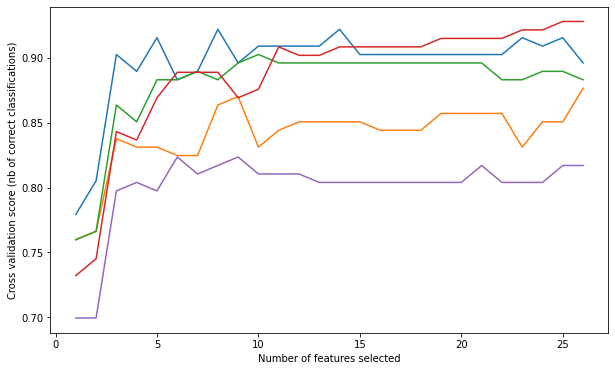

In [ ]:
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=5, scoring='accuracy')
rfecv = rfecv.fit(X_train, y_train)

selected_features = list(X_train.columns[rfecv.support_])

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % selected_features)

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Train/Test split results:
LogisticRegression accuracy is 0.821
LogisticRegression log_loss is 0.371
LogisticRegression auc is 0.916


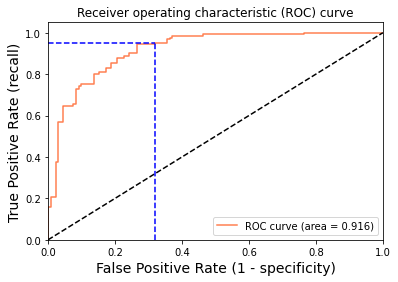

Using a threshold of 0.255 guarantees a sensitivity of 0.952 and a specificity of 0.682, i.e. a false positive rate of 31.82%.


In [ ]:
X_logreg = df[selected_features]
X_train_logregr, X_test_logregr, y_train_logregr, y_test_logregr = train_test_split(X_logreg, y, test_size = 0.25, random_state=42) # уже с отобранными признаками
# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train_scaled_logregr = scaler.fit_transform(X_train_logregr)
# масштабируем тестовую выборку используя статистики обучающей выборки
X_test_scaled_logregr = scaler.transform(X_test_logregr)
logreg = LogisticRegression()
logreg.fit(X_train_scaled_logregr, y_train_logregr)
y_pred = logreg.predict(X_test_scaled_logregr)
y_pred_proba = logreg.predict_proba(X_test_scaled_logregr)[:, 1]  # предсказываем вероятность по классам
[fpr, tpr, thr] = roc_curve(y_test_logregr, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test_logregr, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test_logregr, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # индекс первого threshold с tpr > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

In [ ]:
scores_accuracy = cross_val_score(lr, X_train_scaled_logregr, y_train_logregr, cv=5, scoring='accuracy')
scores_log_loss = cross_val_score(lr, X_train_scaled_logregr, y_train_logregr, cv=5, scoring='neg_log_loss')
scores_auc = cross_val_score(lr, X_train_scaled_logregr, y_train_logregr, cv=5, scoring='roc_auc')
print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average accuracy is 0.874
LogisticRegression average log_loss is 0.320
LogisticRegression average auc is 0.932


Подбор гиперпараметров с помощью GridSearchCV + multiple scorers

Обучаем модель с CV и ищем по сетке гиперпараметр C (чем меньше C тем больше регуляризация).

best estimator: LogisticRegression(C=0.40001000000000003)
best params: {'C': 0.40001000000000003}
best score: 0.8762668703845173


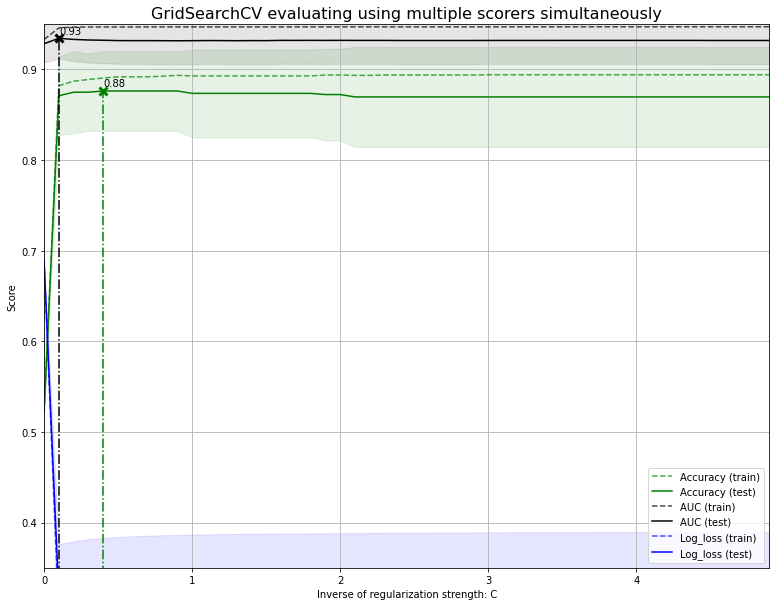

In [ ]:
param_grid = {'C': np.arange(1e-05, 5, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=5, refit='Accuracy')

gs.fit(X_train_scaled_logregr, y_train_logregr)
results = gs.cv_results_

print('='*20)
print("best estimator: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('='*20)

plt.figure(figsize=(13, 10))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",fontsize=16)

plt.xlabel("Inverse of regularization strength: C")
plt.ylabel("Score")
plt.grid()

ax = plt.gca()
ax.set_xlim(0, param_grid['C'].max()) 
ax.set_ylim(0.35, 0.95)

X_axis = np.array(results['param_C'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
        
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

GridSearchCV + multiple scorers + RepeatedStratifiedKFold + pipeline
Поиск по сетке с помощью CV, повторяющийся несколько раз, с масштабированием и различными scorers. StratifiedKFold позволяет разделять выборки с сохранением соотношения объектов каждого класса (стратифицированно).

In [ ]:
model_accuracies = {}  # сюда будем сохранять качество натренированных моделей

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

C = np.arange(1e-05, 5, 0.1)

scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

log_reg = LogisticRegression(random_state=11)

std_scale = StandardScaler()

n_folds=5
n_repeats=5

rskfold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=42)

log_clf_pipe = Pipeline(steps=[('scale',std_scale), ('clf',log_reg)])

log_clf = GridSearchCV(estimator=log_clf_pipe, cv=rskfold,
              scoring=scoring, return_train_score=True,
              param_grid=dict(clf__C=C), refit='Accuracy')

log_clf.fit(X_train_logregr, y_train_logregr)
results = log_clf.cv_results_


print('='*80)
print("best estimator: " + str(log_clf.best_estimator_))
print("best params: " + str(log_clf.best_params_))
print('best score:', log_clf.best_score_)
model_accuracies['Logistic Regression'] = log_clf.score(X_test_logregr, y_test_logregr)
print("test score:", model_accuracies['Logistic Regression'])
#print("test score:", accuracy_score(y_test_logregr, log_clf.best_estimator_.predict(X_test_logregr))) # другой способ
print('='*80)

best estimator: Pipeline(steps=[('scale', StandardScaler()),
                ('clf', LogisticRegression(C=4.20001, random_state=11))])
best params: {'clf__C': 4.20001}
best score: 0.8747254053136406
test score: 0.8210116731517509


In [ ]:
print("Accuracy of Logistic Regression: {:.4f}".format(model_accuracies['Logistic Regression']))

Accuracy of Logistic Regression: 0.8210


## K-Nearest Neighbour (KNN) Classification

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 1)  # n_neighbors means k
knn.fit(X_train_scaled, y_train)
prediction = knn.predict(X_test_scaled)

print("{} NN Score: {:.4f}".format(3, knn.score(X_test_scaled, y_test)))

3 NN Score: 0.9767


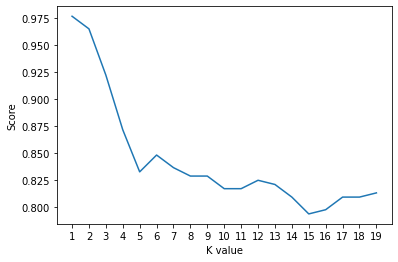

Maximum KNN Score is 0.9767


In [ ]:
scoreList = []
for i in range(1, 20):
    knn2 = KNeighborsClassifier(n_neighbors = i)
    knn2.fit(X_train_scaled, y_train)
    scoreList.append(knn2.score(X_test_scaled, y_test))
    
plt.plot(range(1, 20), scoreList)
plt.xticks(np.arange(1, 20))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)
accuracies['KNN'] = acc
print("Maximum KNN Score is {:.4f}".format(acc))

## Support Vector Machine (SVM)

In [ ]:
svm = SVC(random_state = 12)
svm.fit(X_train_scaled, y_train)

acc = svm.score(X_test_scaled, y_test)
accuracies['SVM'] = acc
print("Test Accuracy of SVM Algorithm: {:.4f}".format(acc))

Test Accuracy of SVM Algorithm: 0.8833


## Naive Bayes Algorithm

In [ ]:
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

acc = nb.score(X_test_scaled, y_test)
accuracies['Naive Bayes'] = acc
print("Accuracy of Naive Bayes: {:.4f}".format(acc))

Accuracy of Naive Bayes: 0.7121


## Decision Tree Algorithm

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

acc = dtc.score(X_test, y_test)
accuracies['Decision Tree'] = acc
print("Decision Tree Test Accuracy {:.4f}".format(acc))

Decision Tree Test Accuracy 0.9883


## Comparing Models

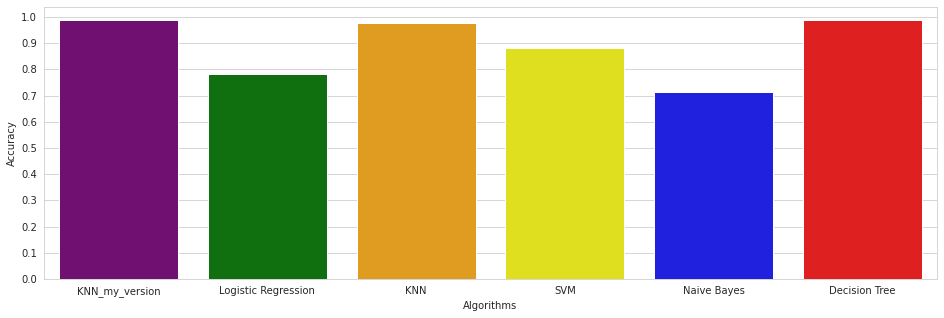

In [ ]:
colors = ["purple", "green", "orange", "yellow", "blue", "red"]

sns.set_style("whitegrid")
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

## Confusion Matrix

In [ ]:
# Predicted values
y_head_lr = lr.predict(X_test_scaled)
knn3 = KNeighborsClassifier(n_neighbors = 1)
knn3.fit(X_train_scaled, y_train)
y_head_knn = knn3.predict(X_test_scaled)
y_head_svm = svm.predict(X_test_scaled)
y_head_nb = nb.predict(X_test_scaled)
y_head_dtc = dtc.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, y_head_lr)
cm_knn = confusion_matrix(y_test, y_head_knn)
cm_svm = confusion_matrix(y_test, y_head_svm)
cm_nb = confusion_matrix(y_test, y_head_nb)
cm_dtc = confusion_matrix(y_test, y_head_dtc)

In [ ]:
cm = [cm_lr, cm_knn, cm_svm, cm_nb, cm_dtc]

In [ ]:
names = ["Logistic Regression Confusion Matrix", "K Nearest Neighbors Confusion Matrix", "Support Vector Machine Confusion Matrix",
         "Naive Bayes Confusion Matrix", "Decision Tree Classifier Confusion Matrix"]

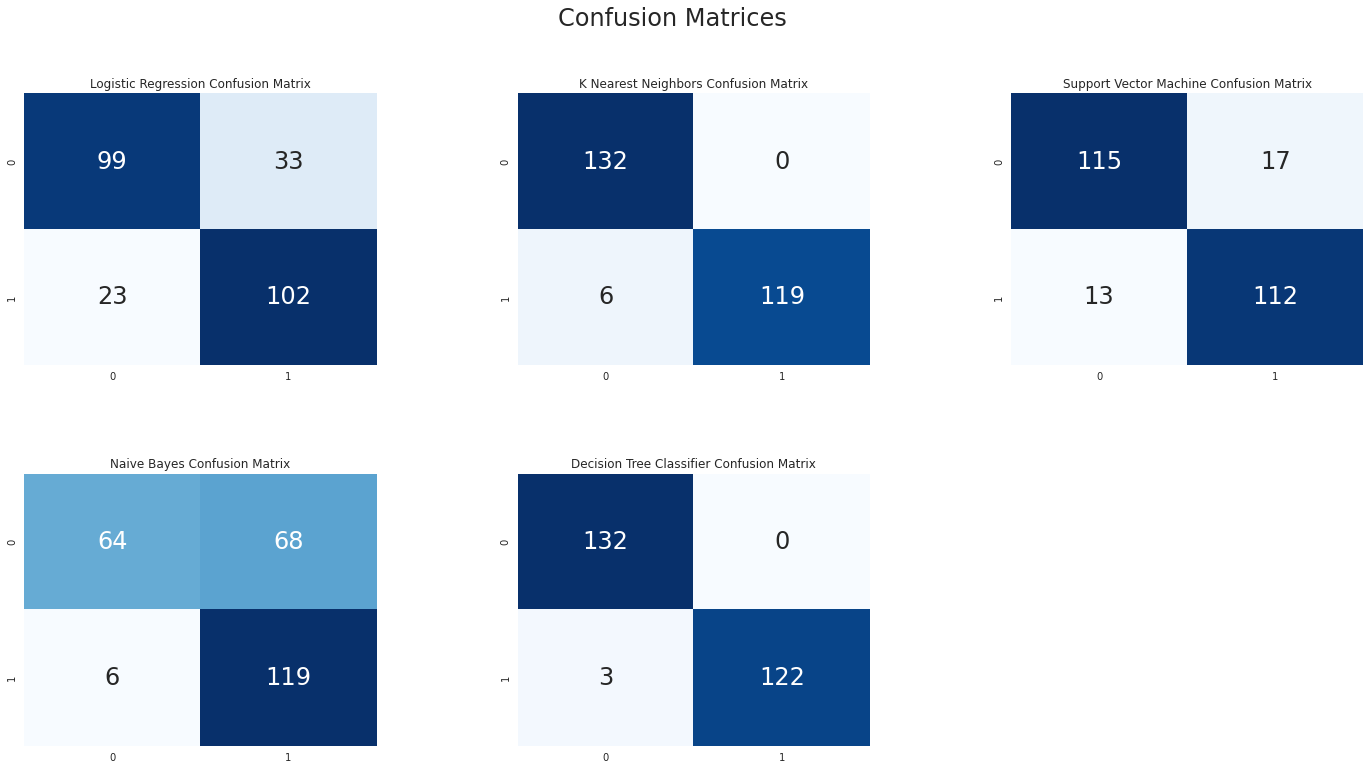

In [ ]:
plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(2,3,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,2)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,3)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,4)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,5)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

Посчитаем FPR, TPR по каждой модели

In [ ]:
i=0
for c in cm:
  TN = c[0][0]
  FN = c[1][0]
  TP = c[1][1]
  FP = c[0][1]

  TPR = TP/(TP+FN)
  FPR = FP/(FP+TN)
  TNR = TN/(FP+TN)
  print(names[i])
  i += 1
  print(TPR, FPR, TNR)

Logistic Regression Confusion Matrix
0.816 0.25 0.75
K Nearest Neighbors Confusion Matrix
0.952 0.0 1.0
Support Vector Machine Confusion Matrix
0.896 0.12878787878787878 0.8712121212121212
Naive Bayes Confusion Matrix
0.952 0.5151515151515151 0.48484848484848486
Decision Tree Classifier Confusion Matrix
0.976 0.0 1.0


По имеющимся данным, можно сделать вывод, что самой опасной ошибкой для определения наличия сердечно-сосудистых заболевнаий будет ошибка I рода, т.е. признать фактически больного человека здоровым. С этой точки зрения, наилучший результат для прогнозирования итогового результата показал алгоритм "дерево решений". У него самый низкий процент ложноотрицательных результатов. При этом, ложноположительных ответов у этого алгоритма вообще нет, т.е. действительно здоровые люди не получат отметку о наличии заболевания. Этот алгоритм обладает высоким значением accuracy (правильности).  На втором месте по качеству полученных результатов выходит алгоритм KNN, который также имеет высокую долю правильности, также не предсказывая ложноположительных результатов, но имеющий большее количество ошибок I рода.



In [ ]:
def log_loss_and_grad(w, X, target):
    m = X.shape[0]
    y=(2*target-1)
    score=np.dot(X, w.T).flatten()
    
    # Рассчёт log_loss
    loss = np.sum(np.log(1+np.exp(-y*score)))/m 
    
    # Рассчёт градиента
    Z=-y/(m*(1+np.exp(y*score)))
    grad=Z[np.newaxis, :].dot(X)
    return loss, grad


def optimize(w, X, y, n_iterations, eta):
    #     потери будем записывать в список для отображения в виде графика
    losses = []
    for i in range(n_iterations):        
        loss, grad = log_loss_and_grad(w, X, y)
        w = w - eta * grad
        losses.append(loss)
        
    return w, losses

def predict(w, X):
    y_predicted = np.zeros(X.shape[0])  
    score=np.dot(X, w.T).flatten()
    Prob = 1/(1+np.exp(-score))
    
    #     За порог отнесения к тому или иному классу примем вероятность 0.5
    y_predicted[Prob>0.5]=1
    y_predicted[Prob<=0.5]=0
        
    return y_predicted

In [ ]:
w0 = np.zeros((1, X_train.shape[1]))

n_iterations = 1000
eta = 0.0001

w, losses = optimize(w0, X_train, y_train, n_iterations, eta)

y_predicted_test = predict(w, X_test)
y_predicted_train = predict(w, X_train)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test)*100.0)

print(f"Итоговый вектор весов w: {w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[-1.90338595e-02 -7.29796861e-03 -2.19851402e-02 -8.48262475e-03
  -4.84718990e-05  3.77462953e-02 -6.66281086e-03 -1.77584165e-02
  -9.42813032e-03  3.07596743e-03  4.83719743e-03  1.08497748e-03
  -1.94305637e-03  1.66608267e-03 -1.53014285e-04 -1.04141352e-04
  -5.81577906e-03  5.48993243e-03  8.26663752e-03 -3.23464695e-03
  -4.12258862e-03 -1.33938993e-03 -1.73967430e-04 -4.77907791e-04
   1.03906121e-02 -1.01687249e-02]]
Точность на обучающей выборке: 66.927
Точность на тестовой выборке: 64.981


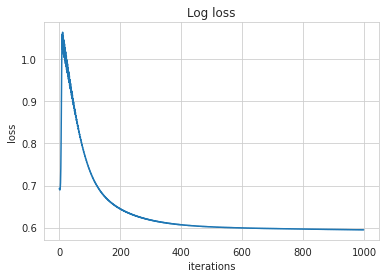

In [ ]:
plt.title('Log loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.plot(range(len(losses)), losses)

Из графика видно, что оптимальное значение loss достигается уже на 500 итерации.

На отмасштабированных данных:

In [ ]:
w0 = np.zeros((1, X_train_scaled.shape[1]))

n_iterations = 1000
eta = 0.015

w, losses = optimize(w0, X_train_scaled, y_train, n_iterations, eta)

y_predicted_test = predict(w, X_test_scaled)
y_predicted_train = predict(w, X_train_scaled)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test)*100.0)

print(f"Итоговый вектор весов w: {w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[ 0.01411791 -0.48797108 -0.1940279  -0.31379177  0.05588996  0.31848035
  -0.27892831 -0.49234334 -0.46639438  0.13426364  0.26823455  0.23465565
  -0.05812879  0.0707603  -0.05570768  0.03043094 -0.26529056  0.25050644
   0.57784019 -0.26908348 -0.42684194 -0.11160366 -0.11027606  0.08804754
   0.3809726  -0.42059524]]
Точность на обучающей выборке: 88.672
Точность на тестовой выборке: 82.490


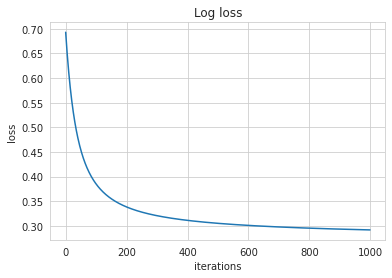

In [ ]:
plt.title('Log loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.plot(range(len(losses)), losses)

In [ ]:
accuracies['Logistic_regression_my_version'] = test_accuracy/100

Comparing Models

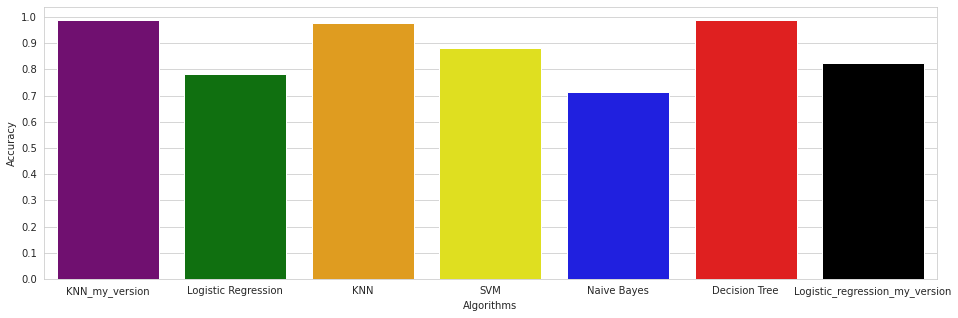

In [ ]:
colors = ["purple", "green", "orange", "yellow", "blue", "red", "black"]

sns.set_style("whitegrid")
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

Последняя модель логистической регрессии в самописной реализации показала результаты лучше, чем пакетная реализация, но не повторила впечатляющих результатов KNN модели и деревьев решений, поэтому выводы остаются прежними (см. под предыдущим графиком Comparing Models)